In [338]:
from math import cos, sin
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np

#### Utils

In [339]:
from typing import Union

DEFAULT_EPSILON = 1e-6
FUNCTION_INPUT_TYPE = Union[np.ndarray, float]


def is_elementwise_close(
        previous: FUNCTION_INPUT_TYPE,
        future: FUNCTION_INPUT_TYPE,
        epsilon: float = DEFAULT_EPSILON
):
    if isinstance(previous, float) and isinstance(future, float):
        return abs(previous - future) < epsilon
    else:
        return np.alltrue(np.abs(previous - future) < epsilon)

#### Learning rate scheduler's

In [340]:
class Scheduler:
    def step(self, *args, **kwargs):
        raise NotImplementedError("`step` method must be implemented by subclasses")


class LearningRateScheduler:
    def __init__(self, lr: float):
        self.lr = lr

    def step(self) -> float:
        return self.lr


class ConstantScheduler(LearningRateScheduler):
    pass


class LinearScheduler(LearningRateScheduler):
    def __init__(self, lr: float, diff: float, every: int, min_lr: float = 0):
        super().__init__(lr)
        self.every = every
        self.steps = 0
        self.diff = diff
        self.min_lr = min_lr

    def step(self) -> float:
        self.steps += 1
        if self.steps % self.every and self.lr > self.min_lr:
            self.lr = max(self.min_lr, self.lr - self.diff)

        return self.lr


class ExponentialScheduler(LearningRateScheduler):
    def __init__(self, lr: float, gamma: float, every: int):
        super().__init__(lr)
        self.gamma = gamma
        self.every = every
        self.steps = 0

    def step(self, *args, **kwargs) -> float:
        self.steps += 1
        if self.steps % self.every == 0:
            self.lr *= self.gamma
        return self.lr

In [341]:
class GradientDescentOptimizer:
    def __init__(
            self,
            function: Callable[[FUNCTION_INPUT_TYPE], float],
            derivative: Callable[[FUNCTION_INPUT_TYPE], np.ndarray],
    ):
        self.function = function
        self.derivative = derivative

    def optimize(
            self,
            initial: np.ndarray,
            iterations: int,
            scheduler: Scheduler,
            epsilon: float = DEFAULT_EPSILON,
            scheduler_parameters=lambda xk, gradient: ()
    ):
        """
        :return: (minimum, trace, steps)
        """
        trace = []
        xk = initial
        iteration = 0
        for iteration in range(iterations):
            trace.append((xk, self.function(xk)))

            gradient = self.derivative(xk)
            params = scheduler_parameters(xk, gradient)
            lr = scheduler.step(*params)

            next_xk = xk - lr * gradient

            if is_elementwise_close(xk, next_xk, epsilon):
                break

            xk = next_xk

        return xk, trace, iteration + 1

#### Visualizing utils

In [342]:
from typing import List
from typing import Tuple
from matplotlib import animation


def animate(
        x_range: np.ndarray,
        f: Callable[[FUNCTION_INPUT_TYPE], float],
        trace: List[Tuple[FUNCTION_INPUT_TYPE, float]],
        output: str,
        fps=10
):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(x_range, f(x_range))

    (x0, y0) = trace[0]
    xs, ys = zip(*trace[1:])

    line, = ax.plot(x0, y0, 'red')  # initial data
    dot = ax.scatter(x0, y0, c='g', marker="o")  # initial point

    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')

    # Function updates data for plot animation using animation.FuncAnimation() below
    # The variable that is passed to this function from FuncAnimation is frames=itersteps-1
    # This acquires the data at every iteration step
    def update(iteration):
        ax.relim()  # resizing plot area
        ax.autoscale_view(True, True, True)  # resizing plot area
        dot.set_offsets([xs[iteration], ys[iteration]])
        ax.set_title(r'Gradient Descent, iteration: ' + str(iteration))
        return line, ax

    # Animation function after all the variables at each iteration have been calculated
    # Calls the function update and passes in the number of frames=itersteps-1 to get all the data at each iteration
    ani = animation.FuncAnimation(fig, update, frames=len(trace) - 1, interval=200, blit=False, repeat_delay=200)

    # Saves animations as .mp4
    filename = f'{output}.mp4'
    # filename = 'quadratic_example_alpha_' + str(a) + '.mp4'
    ani.save(filename, fps=fps, extra_args=['-vcodec', 'libx264'])

In [343]:
def plot1d_descent(minimum_x, f, trace, ax, freq=30, x_range=(-4, 4)):
    colors = ['r', 'g', 'b', 'orange']
    xs_range = np.linspace(*x_range, 500)
    f = np.vectorize(f)
    if isinstance(freq, int):
        trace_len = len(trace) // freq + 1
    else:
        trace_len = 1
    x_trace, y_trace = zip(*trace[::trace_len])

    ax.plot(xs_range, f(xs_range))
    ax.plot(minimum_x, f(minimum_x), marker='o', c=colors[(i + 1) % len(colors)], markersize=10)
    ax.set_xlim(x_range)
    ax.set_ylim(x_range)
    ax.scatter(x_trace, y_trace, c=colors[i % len(colors)])

### 1. Constant learning rate

Function for minimization:
<br>
$f(x)  = cos(x) * x$
<br>
$f'(x) = cos(x) - sin(x) * x$

### Default constants

In [344]:
COS_MUL_X = np.vectorize(lambda x: cos(x) * x)
COS_MUL_X_GRAD = np.vectorize(lambda x: cos(x) - sin(x) * x)
ITERATIONS = 50_000
INITIAL = 0.8

In [345]:
lrs = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

data = []

for lr in lrs:
    scheduler = ConstantScheduler(lr)
    optimizer = GradientDescentOptimizer(COS_MUL_X, COS_MUL_X_GRAD)
    result = optimizer.optimize(INITIAL, ITERATIONS, scheduler)
    data.append((*result, lr))

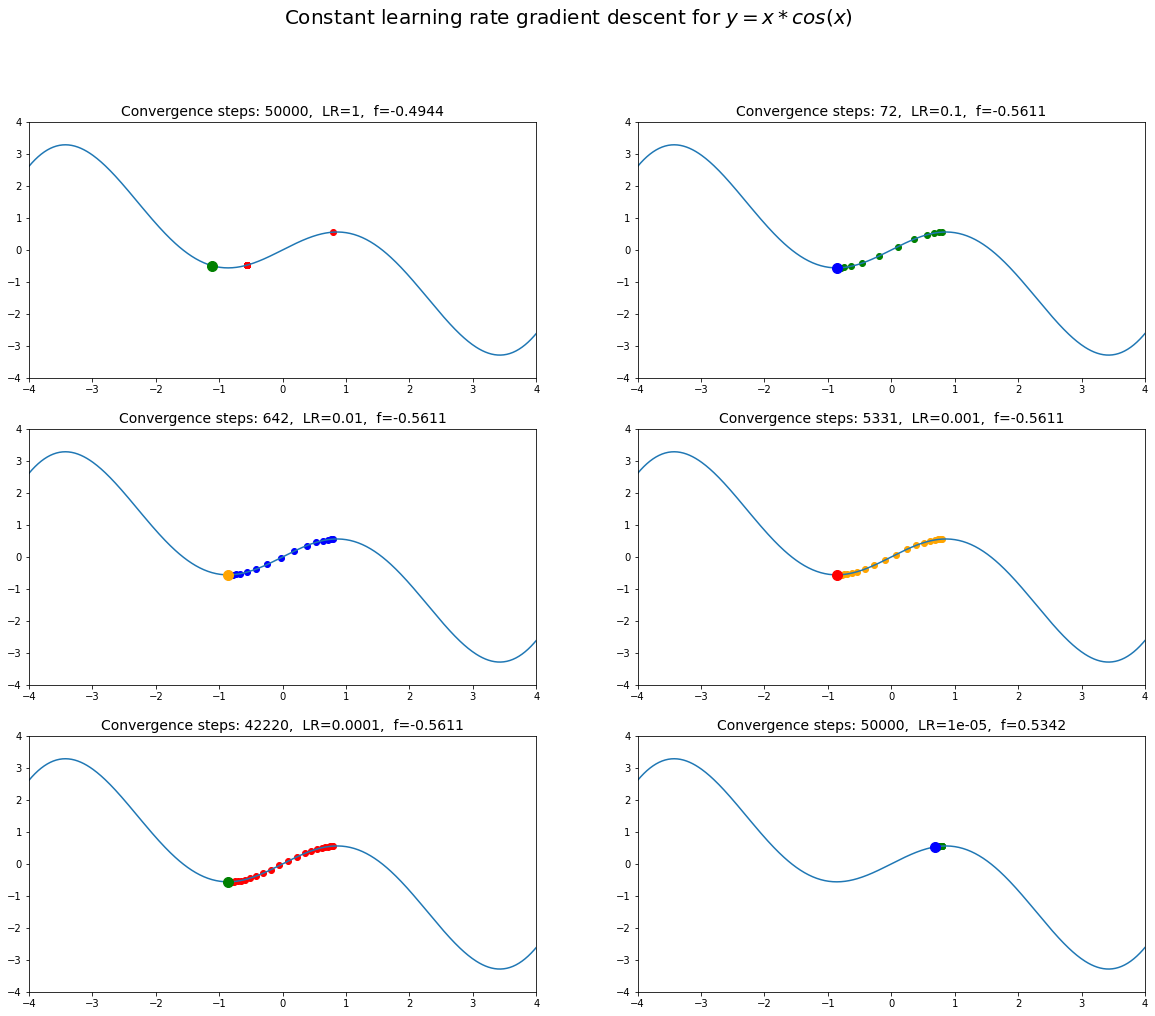

In [346]:
cols = 2
rows = len(data) // cols

figure, axs = plt.subplots(rows, cols, figsize=(20, 16))
figure.suptitle("Constant learning rate gradient descent for $y = x * cos(x)$", fontsize=20)

for i, (minimum_x, trace, made_steps, lr) in enumerate(data):
    col = i % 2
    row = i // 2
    ax = axs[row][col]

    plot1d_descent(minimum_x, COS_MUL_X, trace, ax)
    ax.set_title(f"Convergence steps: {made_steps},  LR={lr},  f={COS_MUL_X(minimum_x):.4}", fontsize=14)

plt.show()

### 2. Exponential learning rate scheduling

In [347]:
LR = 1.5
gammas = [0.99, 0.9, 0.5, 0.1]

data = []

for gamma in gammas:
    scheduler = ExponentialScheduler(LR, gamma=gamma, every=10)
    optimizer = GradientDescentOptimizer(COS_MUL_X, COS_MUL_X_GRAD)
    result = optimizer.optimize(INITIAL, ITERATIONS, scheduler)
    data.append((*result, gamma, scheduler.lr))

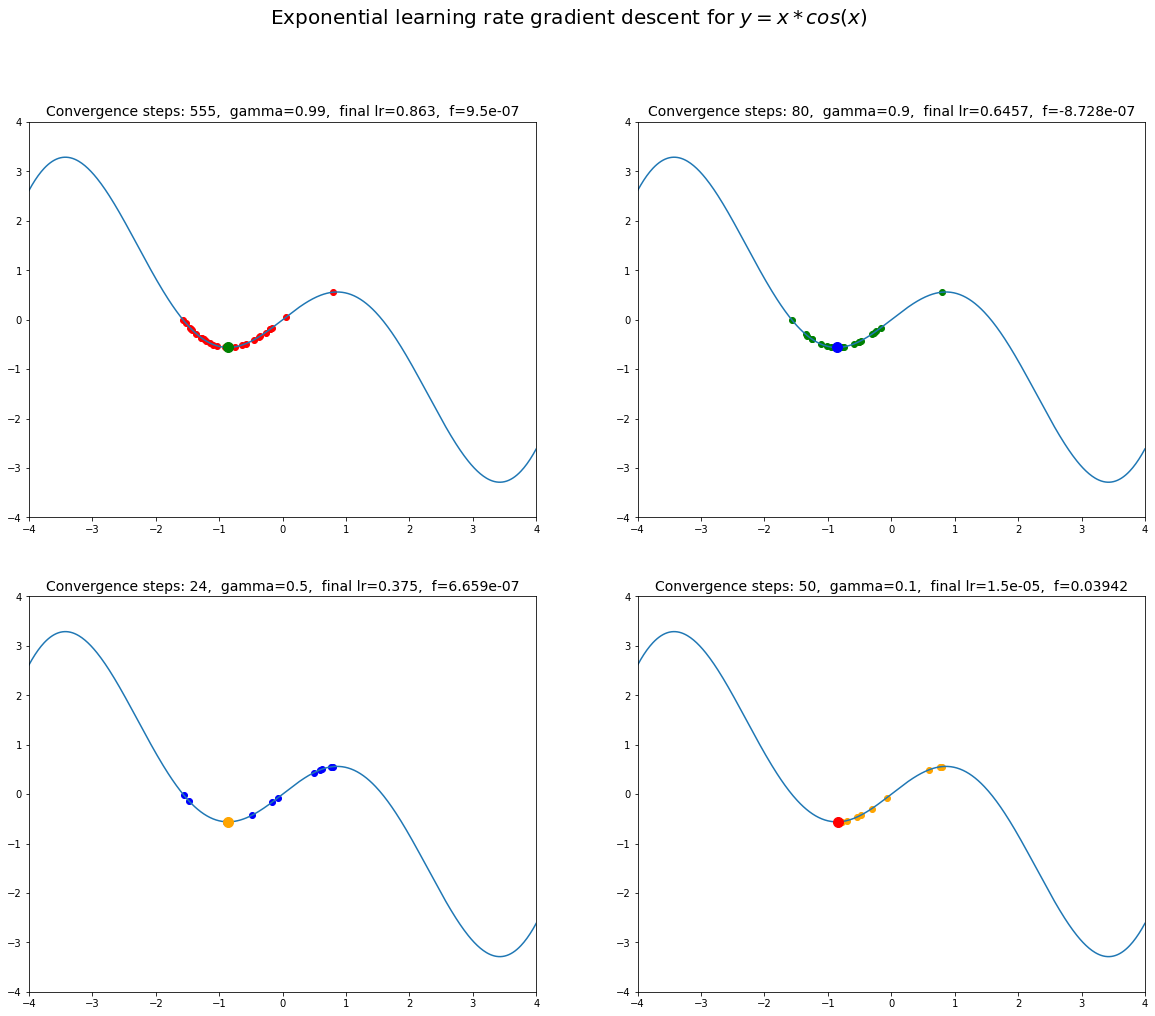

In [348]:
cols = 2
rows = len(data) // cols

figure, axs = plt.subplots(rows, cols, figsize=(20, 16))
figure.suptitle("Exponential learning rate gradient descent for $y = x * cos(x)$", fontsize=20)

for i, (minimum_x, trace, made_steps, gamma, lr) in enumerate(data):
    col = i % 2
    row = i // 2
    ax = axs[row][col]

    plot1d_descent(minimum_x, COS_MUL_X, trace, ax)
    ax.set_title(
        f"Convergence steps: {made_steps},  gamma={gamma},  final lr={lr:.4},  f={COS_MUL_X_GRAD(minimum_x):.4}",
        fontsize=14)

plt.show()

In [349]:
# Uncomment if new animation is required.

# x_range = np.linspace(-4, 4, 200)
# cos_mul_x = np.vectorize(lambda x: cos(x) * x)
#
# trace = data[1][1]
# video_suffix = 'gamma_0.9'
#
# animate(x_range, cos_mul_x, trace, fps=10, output=f'video/{video_suffix}')

In [350]:
# from video_utils import convert_mp4_to_jpgs, make_gif
#
# convert_mp4_to_jpgs(f'video/{video_suffix}.mp4', f'frames/{video_suffix}')
# make_gif(f'gifs/{video_suffix}.gif', f'frames/{video_suffix}')

Gradient descent visualization for $y(x) = cos(x) * x$, initial *learning rate = 1.5*
<br>
#### $gamma = 0.99$
<img src="gifs/gamma_0.99.gif" width="500">

#### $gamma = 0.9$
<img src="gifs/gamma_0.9.gif" width="500">

#### $gamma = 0.1$
<img src="gifs/gamma_0.1.gif" width="500">

### 3. Dichotomy (Fastest descent method)

In [351]:
def dichotomy(func, epsilon):
    delta = epsilon / 3

    def step(interval):
        def internal_step(new_range, trace: List):
            a, b = new_range

            mid = (a + b) / 2

            trace.append((mid, func(mid)))

            if b - a < epsilon:
                return mid

            x1, x2 = mid - delta, mid + delta
            fx1, fx2 = func(x1), func(x2)

            if fx1 < fx2:
                new_range = (a, x2)
            elif fx1 > fx2:
                new_range = (x1, b)
            else:
                new_range = (x1, x2)

            return internal_step(new_range, trace)

        trace = []
        x = internal_step(interval, trace)
        return x, trace

    return step

### Testing naive dichotomy algorithm for

$y(x) = -x * sin(x) + cos(x) * x ^ 2 + 0.001 * x ^ 3$

In [352]:
y = lambda x: -x * sin(x) + cos(x) * x ** 2 + (x ** 3) / 1000

dichotomy_search = dichotomy(y, 1e-4)

x, trace = dichotomy_search((-20, 20))
x, y(x)

(-3.4081116141160326, -10.347107429820403)

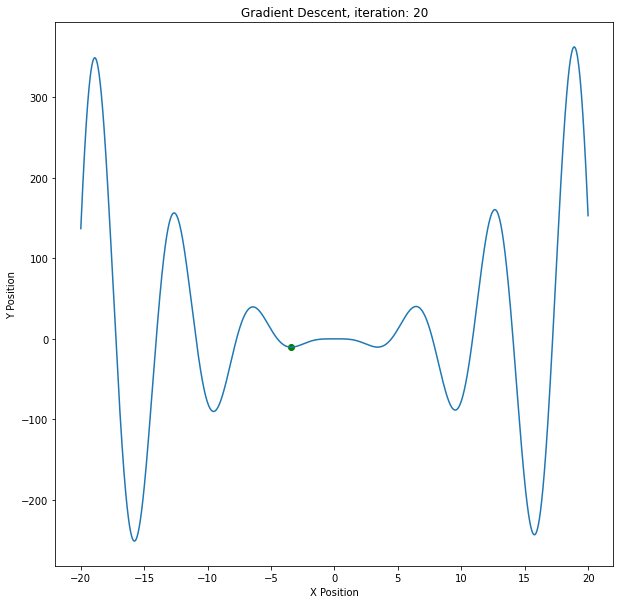

In [353]:
animate(
    x_range=np.linspace(-20, 20, 100000),
    f=np.vectorize(y),
    trace=trace,
    output='video/naive_dichotomy',
    fps=5
)

In [354]:
from video_utils import convert_mp4_to_jpgs, make_gif

video_suffix = "naive_dichotomy"

convert_mp4_to_jpgs(f'video/{video_suffix}.mp4', f'frames/{video_suffix}')
make_gif(f'gifs/{video_suffix}.gif', f'frames/{video_suffix}')

#### Naive dichotomy steps
<br>
<img src="gifs/naive_dichotomy.gif"/>

#### Testing gradient descent with dichotomy learning rate searching

$y(x) = cos(x) * x$

In [355]:
def linear_search(f):
    alpha = 0.5

    f_zero = f(0)
    f_alpha = f(alpha)

    while f_zero < f_alpha:
        alpha /= 2
        f_alpha = f(alpha)

    if alpha == 0:
        return 1e-4

    right_border = 2 * alpha

    for _ in range(100):
        if f(right_border) >= f_alpha:
            break

        right_border *= 2

    return right_border

In [356]:
class DichotomyScheduler(Scheduler):
    def __init__(self, f, epsilon=1e-4, log=True):
        self.f = f
        self.epsilon = epsilon
        self.log = log

    def step(self, xk, gradient):
        phi = lambda lr: self.f(xk - lr * gradient)
        max_alpha = linear_search(phi)
        interval = 0, max_alpha
        dichotomy_algorithm = dichotomy(phi, self.epsilon)
        alpha, trace = dichotomy_algorithm(interval)

        if self.log:
            print(f'f({xk}) = {phi(0):.3}, f({xk - max_alpha * gradient})={phi(max_alpha):.3}')
            for (a, phi_a) in trace:
                print(xk - a * gradient, phi_a)

            print('\n\n')

        return alpha

In [357]:
initial = -3.0

scheduler = DichotomyScheduler(f=COS_MUL_X, epsilon=1e-1, log=True)
optimizer = GradientDescentOptimizer(COS_MUL_X, COS_MUL_X_GRAD)

minimum_x, trace, steps = optimizer.optimize(
    initial=initial,
    iterations=ITERATIONS,
    scheduler=scheduler,
    epsilon=1e-8,
    scheduler_parameters=lambda xk, grad: (xk, grad)
)

f(-3.0) = 2.97, f(19.613640332480752)=14.2
8.306820166240376 -3.6343976873632218
13.936674374014231 2.7755173451554978
16.751601477901158 -8.427384049335346
15.344137925957696 -14.339747635987925
16.04786970192943 -15.129704709696796
15.696003813943562 -15.694881339066972
15.871936757936496 -15.659037618000294
15.783970285940029 -15.738399705740544
15.739987049941796 -15.731916883330358
15.761978667940912 -15.738990183723208



f(15.761978667940912) = -15.7, f(15.798870140819666)=-15.7
15.78042440438029 -15.739014051550816
15.773660967685851 -15.739632168758455
15.770279249338632 -15.739668939848746
15.771970108512242 -15.739673237069322



f(15.771970108512242) = -15.7, f(15.769251971765437)=-15.7
15.77061104013884 -15.739673360178358
15.771109365209087 -15.73967671776677
15.77135852774421 -15.739676919098388
15.771233946476649 -15.739676941557681



f(15.771233946476649) = -15.7, f(15.771435956086187)=-15.7
15.771334951281418 -15.739676942240187
15.771297916186336 -15.739676960784488

15.77128487326584


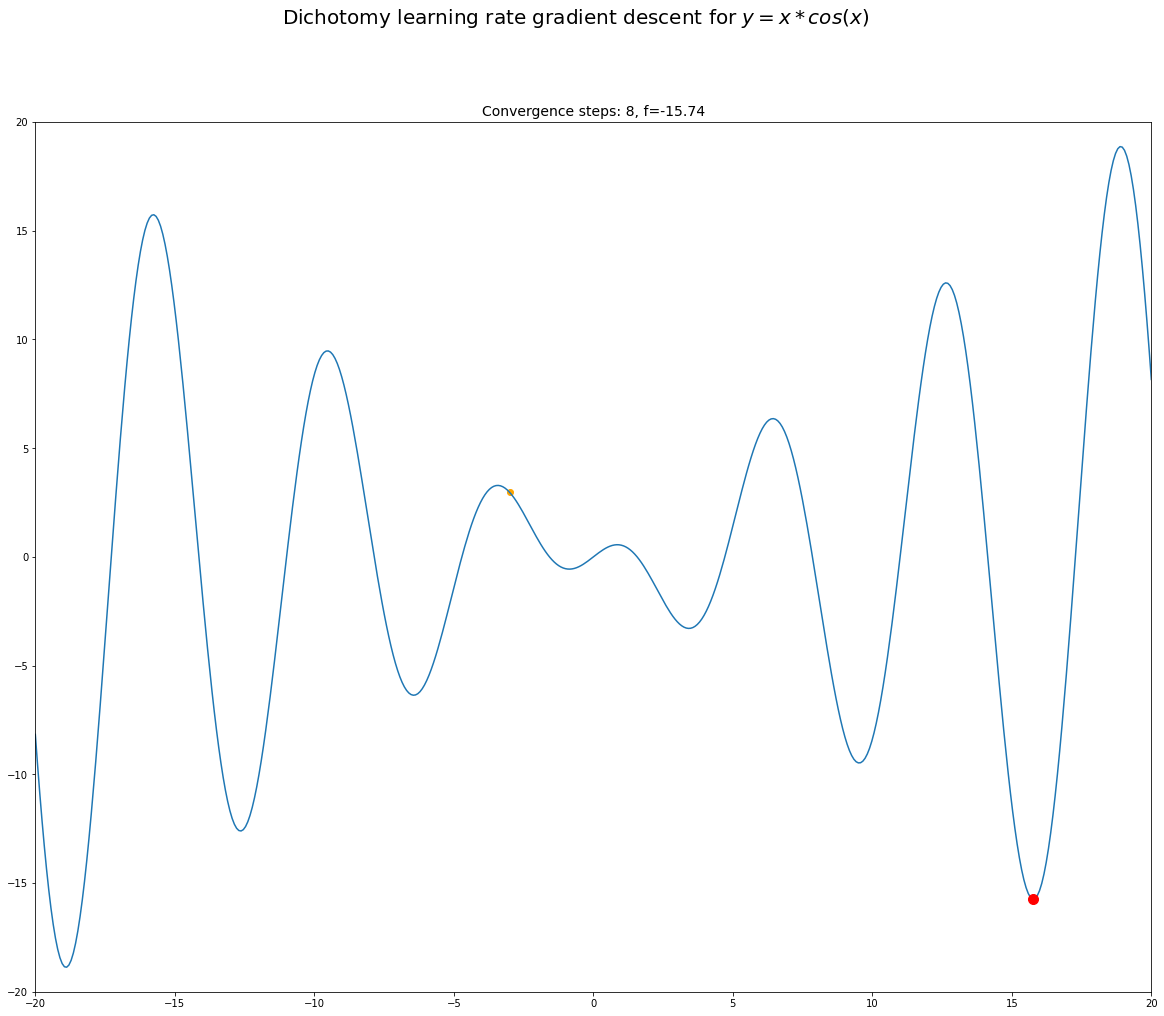

In [358]:
figure, ax = plt.subplots(figsize=(20, 16))
figure.suptitle("Dichotomy learning rate gradient descent for $y = x * cos(x)$", fontsize=20)

ax.set_title(f"Convergence steps: {steps}, f={COS_MUL_X(minimum_x):.4}", fontsize=14)
print(minimum_x)
plot1d_descent(minimum_x, COS_MUL_X, trace, ax, freq='every', x_range=(-20, 20))

We can see than now gradient calculates only ones, but function may be calculated several times:

1. In Linear Search we execute f(x) every time while f(alpha) < f(0).
2. In Dichotomy algorithm we evaluate function $O(ln(alpha) / ε)$ times

### *4. Wolfe conditions

1. $f(x_k + \alpha * p_k) \le f(x_k) + c_1 * \alpha * \nabla f(x_k) * p_k$, $c1 \ge 0$, $\alpha \ge 0$
2. $\nabla f(x_k + \alpha * p_k) * p_k \ge c_2 * \nabla f(x_k) * p_k$, $c_1 \le c_2 \le 1$

In [359]:
def wolfe(f, gradient, xk, projection, c1=1e-4, c2=0.9, max_iterations=100):
    y_xk = f(xk)
    grad_xk = gradient(xk)

    def step(interval, made_iterations=0):
        if made_iterations == max_iterations:
            return 1e-4

        l, r = interval
        alpha = (l + r) / 2
        y_step = f(xk + alpha * projection)

        # If first Wolfe condition is false we need to decrease right border.
        if y_step > y_xk + c1 * alpha * grad_xk * projection:
            return step((l, alpha), made_iterations + 1)
        else:
            step_grad = gradient(xk + alpha * projection)
            # If both Wolfe condition is correct returning alpha.
            if step_grad * projection >= c2 * grad_xk * projection:
                return alpha

            # If second condition isn't correct we need to make step in
            else:
                return step(
                    interval=(l, alpha),
                    made_iterations=made_iterations + 1
                ) if step_grad >= 0 else step(
                    interval=(alpha, r),
                    made_iterations=made_iterations + 1
                )

    return step

In [360]:
class WolfeScheduler(Scheduler):
    def __init__(self, f, grad_f, c1=1e-2, c2=0.9, max_step_iterations=100):
        self.f = f
        self.grad_f = grad_f
        self.c1 = c1
        self.c2 = c2
        self.max_step_iterations = max_step_iterations

    @property
    def wolfe(self):
        return lambda xk, projection, interval: wolfe(
            f=self.f,
            gradient=self.grad_f,
            xk=xk,
            projection=projection,
            c1=self.c1,
            c2=self.c2,
            max_iterations=self.max_step_iterations
        )(interval)

    def step(self, xk, gradient):
        phi = lambda lr: self.f(xk - lr * gradient)
        max_alpha = linear_search(phi)
        interval = 0, max_alpha
        alpha = self.wolfe(xk=xk, projection=gradient, interval=interval)
        return alpha

In [361]:
initial = -3.0

scheduler = WolfeScheduler(f=COS_MUL_X, grad_f=COS_MUL_X_GRAD, c1=1e-4, c2=0.9, max_step_iterations=10)
optimizer = GradientDescentOptimizer(COS_MUL_X, COS_MUL_X_GRAD)

minimum_x, trace, steps = optimizer.optimize(
    initial=initial,
    iterations=ITERATIONS,
    scheduler=scheduler,
    epsilon=1e-8,
    scheduler_parameters=lambda xk, grad: (xk, grad)
)

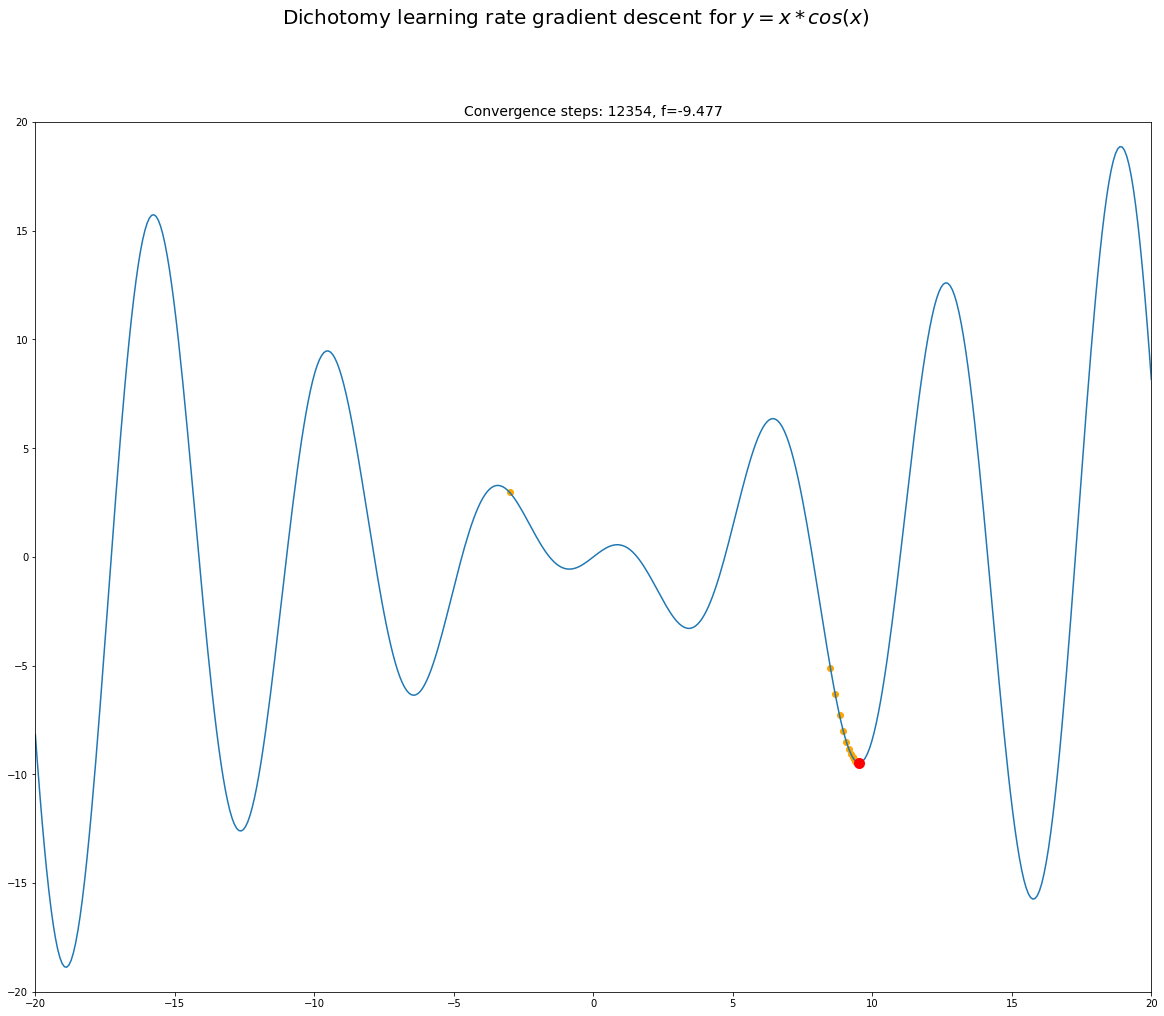

In [362]:
figure, ax = plt.subplots(figsize=(20, 16))
figure.suptitle("Dichotomy learning rate gradient descent for $y = x * cos(x)$", fontsize=20)

ax.set_title(f"Convergence steps: {steps}, f={COS_MUL_X(minimum_x):.4}", fontsize=14)
plot1d_descent(minimum_x, COS_MUL_X, trace, ax, freq=50, x_range=(-20, 20))

### 5. K-Dimensional functions

#### Multi-dimensional function visualisation utils

In [367]:
from matplotlib.colors import ListedColormap
from matplotlib import cm
import numpy as np


def plot_3d_descent(f, trace, color=cm.coolwarm, angle=(0, 0), title=''):
    fig = plt.figure(figsize=(15, 20))
    fig.suptitle(title, fontsize=15)

    ax3d = fig.add_subplot(211, projection='3d')
    axheat = fig.add_subplot(212)

    levels = [x ** 3 for x in range(8)]
    r = np.linspace(240, 166, 256) / 255.
    g = np.linspace(244, 188, 256) / 255.
    b = np.linspace(246, 203, 256) / 255.
    cmap = ListedColormap(np.vstack((r, g, b)).T)

    X = np.linspace(-5, 5, 200)
    Y = np.linspace(-5, 5, 200)

    X, Y = np.meshgrid(X, Y)
    Z = f(X, Y)

    ax3d.plot_surface(X, Y, Z, cmap=color, rstride=2, cstride=2, alpha=0.6)
    trace_xs, z_trace = zip(*trace)
    trace_xs = np.array(trace_xs)
    x_trace, y_trace = trace_xs[:, 0], trace_xs[:, 1]
    z_trace = np.array(z_trace)

    ax3d.scatter(x_trace, y_trace, z_trace, c='green', s=10)
    ax3d.set_xlabel('x')
    ax3d.set_ylabel('y')
    ax3d.set_zlabel('z')

    ax3d.view_init(*angle)

    axheat.contourf(X, Y, Z, levels=levels, cmap=cmap)
    cs = axheat.contour(X, Y, Z, levels=levels, colors="#ABBECC")
    axheat.clabel(cs, colors="#2618B1")
    axheat.plot(x_trace, y_trace, '-og', linewidth=.5, ms=1.5)

    plt.show()

#### Testing $z = 5 * (y - x)^2 + (1-x)^2$

In [368]:
def f1_multi(xs):
    [x, y] = xs
    return 5 * (y - x) ** 2 + (1 - x) ** 2


def f1_grad_multi(xs):
    [x, y] = xs
    return np.array([10 * (x - y) + 2 * x - 2, 10 * (y - x)])

In [391]:
scheduler = ExponentialScheduler(1e-3, gamma=0.99, every=25)
optimizer = GradientDescentOptimizer(f1_multi, f1_grad_multi)
x_minimum, trace, iterations = optimizer.optimize(
    initial=np.array([-5.0, 5.0]),
    iterations=ITERATIONS,
    scheduler=scheduler
)

print(f'x_min = {x_minimum}, f(x_min) = {f1_multi(x_minimum):.4}, convergance iterations = {iterations}')

x_min = [0.9316145  0.92443487], f(x_min) = 0.004934, convergance iterations = 10650


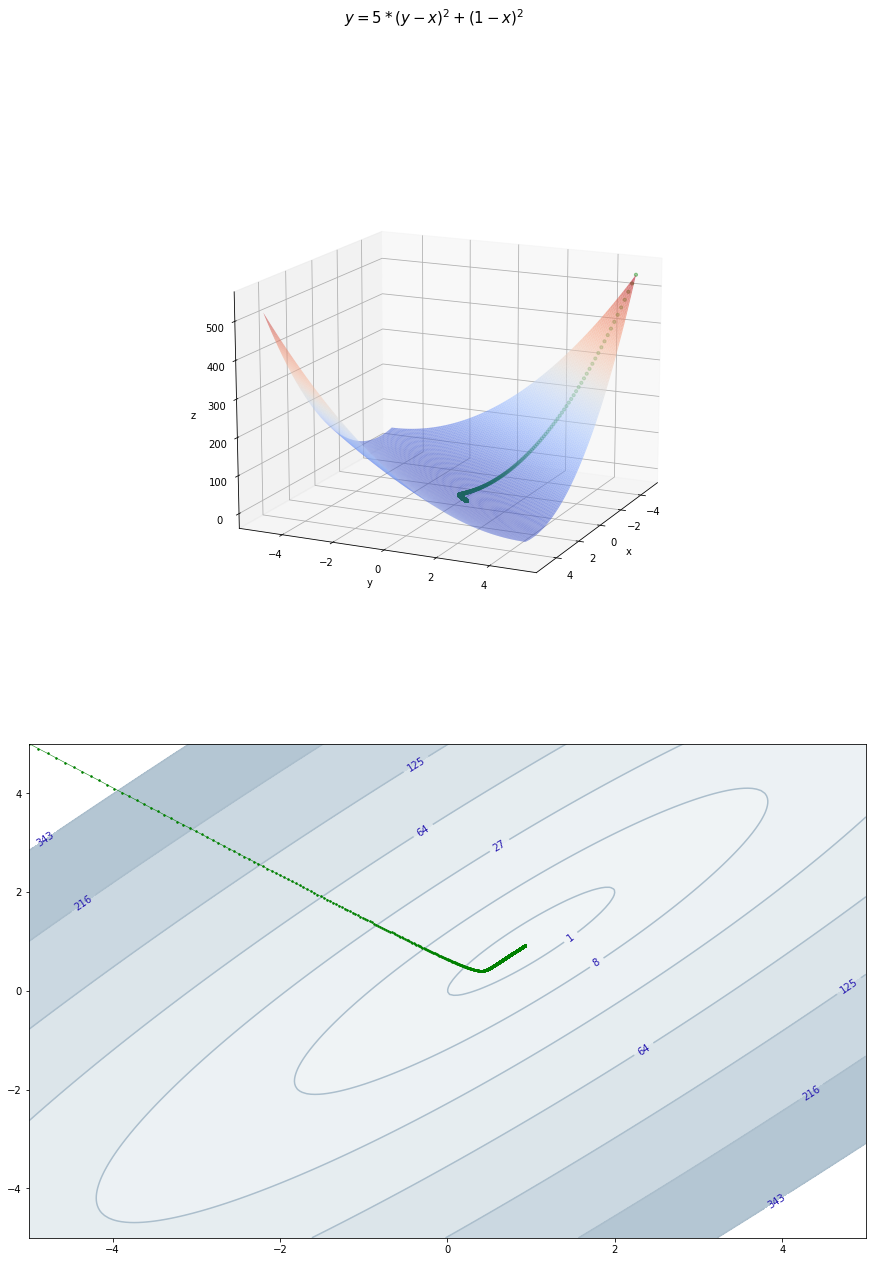

In [392]:
plot_3d_descent(
    f=lambda x, y: 5 * (y - x) ** 2 + (1 - x) ** 2,
    trace=trace,
    color=cm.coolwarm,
    angle=(15, 25),
    title='$y = 5 * (y - x)^2 + (1 - x)^2$'
)

#### Testing $(x^2 + y - 5)^2 + (x + y^2 - 2)^2 + 2$

In [406]:
def f2_multi(xs):
    [x, y] = xs
    return (x ** 2 + y - 5) ** 2 + (x + y ** 2 - 2) ** 2 + 2


def f2_grad_multi(xs):
    [x, y] = xs
    return np.array([
        x * (4 * x ** 2 + 4 * y - 18) + 2 * y ** 2 - 4,
        2 * (x + y) ** 2 + 2 * (2 * y ** 3 - y ** 2 - 3 * y - 5)
    ])

In [421]:
scheduler = ExponentialScheduler(1e-3, gamma=0.99, every=50)
optimizer = GradientDescentOptimizer(f2_multi, f2_grad_multi)
x_minimum, trace, iterations = optimizer.optimize(
    initial=np.array([6, 6]),
    iterations=ITERATIONS,
    scheduler=scheduler
)

print(f'x_min = {x_minimum}, f(x_min) = {f2_multi(x_minimum):.4}, convergance iterations = {iterations}')

x_min = [2.19648036 0.12680739], f(x_min) = 2.048, convergance iterations = 11700


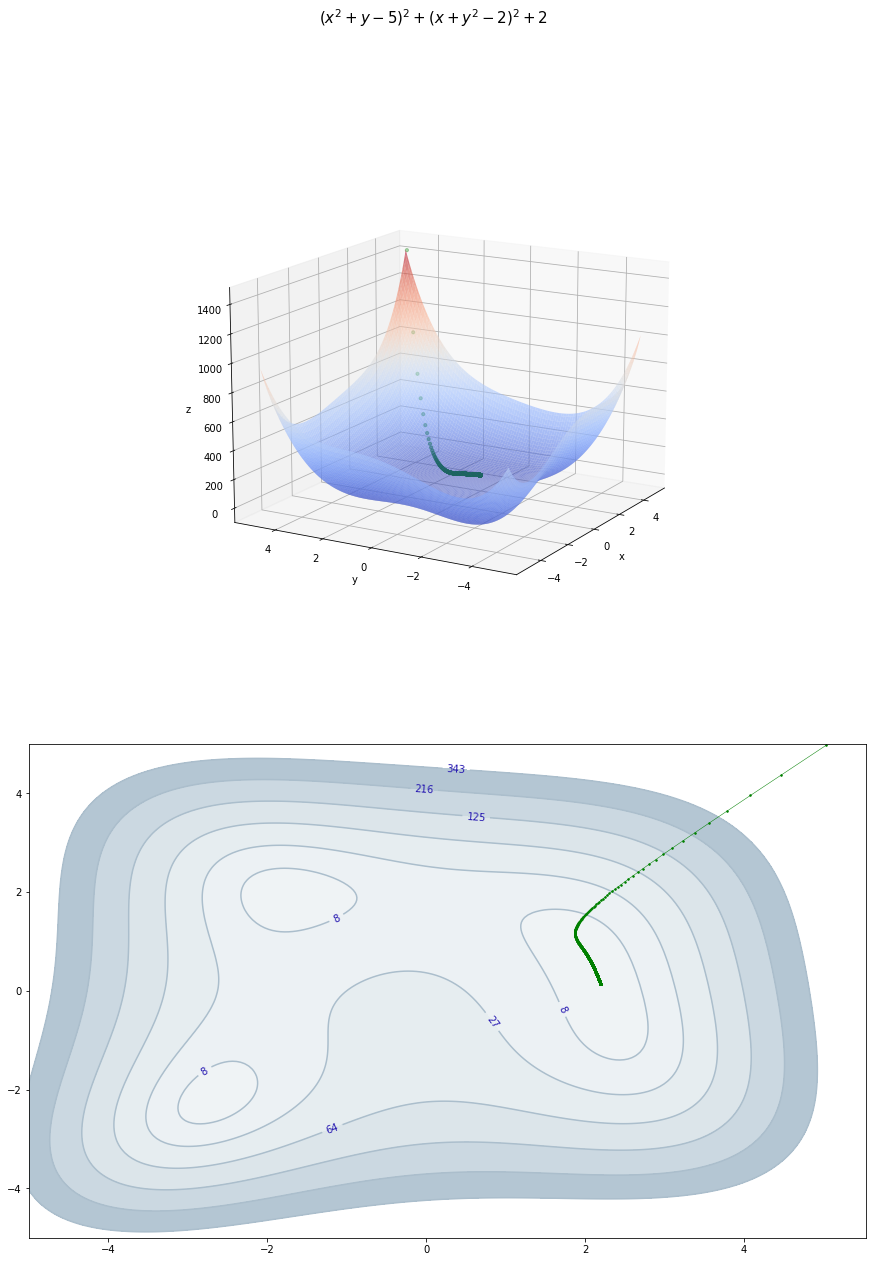

In [422]:
plot_3d_descent(
    f=lambda x, y: (x ** 2 + y - 5) ** 2 + (x + y ** 2 - 2) ** 2 + 2,
    trace=trace[1:],
    color=cm.coolwarm,
    angle=(15, -150),
    title='$(x^2 + y - 5)^2 + (x + y^2 - 2)^2 + 2$'
)